<a href="https://colab.research.google.com/github/StevenBryceLee/Counterfactual-Regret-Minimization/blob/master/module4-classification-metrics/Copy_of_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [27]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [28]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [81]:
def dimensionalityReduce(df):
  '''
  This function finds high dimensionality, string columns, and replaces
  features which are not in the top 10 most common features with other
  
  df is a pandas dataframe
  
  returns the pandas dataframe with columns reduced'''
  df = df.copy()
  #Get categorical columns as a list
  cate_cols = df.describe(include='object').columns.tolist()
  
  #Replace all categorical columns with high dimensionality with other
  #print('DR catecols:\t',cate_cols)
  for col in cate_cols:
    #do nothing if cardinality is less than 16
    if(len(df[col].value_counts()) < 16 or col == 'region_code' or col == 'district_code'):
      continue
    
    #Get top 15 values
    top15 = train[col].value_counts()[:15].index
    #Replace values
    df.loc[~df[col].isin(top15), col] = 'OTHER'

  return df

#Drop columns with high NaN values, with 40% of values as NaN cutoff
def NaNdrop(df, cutoff = 0.4):
  '''
  This function drops all columns which have high NaN values from a dataframe

  df is a pandas dataframe
  cutoff is the percent of NaN values in the column at which the column should be dropped

  returns a df
  '''
  df = df.copy()
  df = df.dropna(axis = 1, thresh = int(len(df) * cutoff))
  df = df.interpolate().bfill().ffill()
  return df
def dropCorr(df):
  '''
  This function drops highly correlated columns from the dataframe

  df is a pandas dataframe
  '''
  df = df.copy()
  # Create correlation matrix
  corr_matrix = df.corr().abs()

  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  # Find index of feature columns with correlation greater than 0.95
  to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
  return df.drop(to_drop, axis=1)
def wrangle(df):
  '''
  This function wrangles and cleans a dataset for waterpumps from driven data
  '''
  import numpy as np
  import pandas as pd
  df = df.copy()
  #Get the index
  df.index = df.id
  #Fix the date columns and expand into separate datasets
  df['date_recorded'] = pd.to_datetime(df['date_recorded'])
  df['year'] = df['date_recorded'].apply(lambda x: x.year)
  df['month'] = df['date_recorded'].apply(lambda x: x.month)
  df['day'] = df['date_recorded'].apply(lambda x: x.day)
  
  #Finding all the random values and replacing them
  for col in df.columns:
    df[col].replace(['None','unknown','0',
                     -2.000000e-08,'none','1'],np.nan,inplace = True)
  #specific changes to each column
  df.region_code = df.region_code.apply(lambda x: str(x))
  #print('region_code')
  #print(df.region_code.value_counts())
  df.district_code = df.district_code.apply(lambda x: str(x))
  #print('district_code')
  #print(df.district_code.value_counts())
  df.population.replace([0,1],np.nan,inplace = True)
  df.longitude.replace(0,np.nan,inplace=True)
  df.construction_year.replace(0,np.nan,inplace=True)
  #Drop all redundant and unnecessary columns
  df.drop(['extraction_type','extraction_type_group','recorded_by',
           'quality_group','quantity_group','waterpoint_type_group',
           'num_private','id','date_recorded'],axis=1,inplace=True)
  #Reduce dimensionality, then drop NaNs
  df = NaNdrop(dimensionalityReduce(df))
  df = dropCorr(df)
  return df
train = wrangle(train)
test = wrangle(test)

In [31]:
from sklearn.pipeline import Pipeline
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score as A_S

import numpy as np

In [32]:
#First, test with defaults
X = train.drop('status_group',axis=1)
y = train.status_group
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.04, random_state=42,stratify=y)

In [33]:
y_train.value_counts()

functional                 30969
non functional             21911
functional needs repair     4144
Name: status_group, dtype: int64

In [34]:
#Collapsing the labels to 0 and 1
mapDict = {'functional':'functional',
               'non functional': 'non functional',
               'functional needs repair': 'non functional'
           }
yT_train = y_train.apply(lambda x: mapDict[x])
yT_test = y_test.apply(lambda x: mapDict[x])

In [35]:
yT_train.value_counts()

functional        30969
non functional    26055
Name: status_group, dtype: int64

In [60]:
params = {'model__n_estimators':np.linspace(100,150,10,dtype='int64'),
          #'model__max_depth':[None] + np.linspace(5000,53460,5,dtype='int64').tolist(),
          #'model__min_samples_split':np.linspace(2,20,5,dtype='int64'),
          #'model__min_samples_leaf': np.linspace(1,20,5,dtype='int64'),
          # 'model__min_weight_fraction_leaf': np.linspace(0,0.9,5),
          #'model__max_features':['log2'] + np.linspace(np.sqrt(len(X_train.columns)),len(X_train.columns)-2,5).tolist(),
          #'model__max_leaf_nodes':np.linspace(10000,53460,5,dtype='int64').tolist(),
          #'model__min_impurity_decrease':np.linspace(0,0.9,5),
          # 'model__bootstrap':[True,False],
          #'model__class_weight':['balanced','balanced_subsample'],
          #'model__ccp_alpha':np.linspace(0,0.6,5).tolist(),
          }

pipe = Pipeline([#Encode categorical columns
                 ('cust_transform',FunctionTransformer(wrangle)),
                ('oneHot',OrdinalEncoder()),
                #Scale numeric columns
                ('scaler',StandardScaler()),
                #Instantiate the model
                ('model',RandomForestClassifier(random_state=91))])
grid = RandomizedSearchCV(pipe, param_distributions =params,n_jobs=-1,cv = 3)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)

# pipe.fit(X_train,y_train)
# y_pred = pipe.predict(X_test)

print('Score:\t',A_S(y_test,y_pred))

Score:	 0.805976430976431


In [61]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('cust_transform',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function wrangle at 0x7efbfa240e18>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('oneHot',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region',
                                      'region_code', 'district_code', 'lga',
                                      'ward', 'sche...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                   

In [63]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

In [57]:
from sklearn.preprocessing import label_binarize
yTT_train = label_binarize(y_train,y_train.value_counts().index)
yTT_test = label_binarize(y_test,y_test.value_counts().index)

In [ ]:
#Trying a stacking classifier
preds = []
estimators = [
              ('rf',RandomForestClassifier(random_state=91)),
              ('svc',LinearSVC(random_state=91)),
              ('knn',KNeighborsClassifier())
              ]
final_estimators = [LogisticRegression()
                    #RidgeClassifier(),
                    #KNeighborsClassifier() #No improvement
                    ]
for fe in final_estimators:
  model = StackingClassifier(estimators = estimators, n_jobs=-1,final_estimator=fe)

  pipe = Pipeline([#Encode categorical columns
                  ('cust_transform',FunctionTransformer(wrangle)),
                  ('oneHot',OrdinalEncoder()),
                  #Handle missing data
                  #('impute',SimpleImputer(strategy = 'most_frequent')),
                  #Scale numeric columns
                  ('scaler',StandardScaler()),
                  #Instantiate the model
                  ('model',model)])

  pipe.fit(X_train,y_train)
  y_pred = pipe.predict(X_test)
  score = A_S(y_test,y_pred)
  print('Score:\t',score)
  if score > 0.81:
    preds.append((y_pred,fe))

In [84]:
#Testing if label transformation increases accuracy
#Testing if dropping highly correlated features increases accurace
#It did not
pipe = Pipeline([#Encode categorical columns
                 ('cust_transform',FunctionTransformer(wrangle)),
                ('oneHot',OrdinalEncoder()),
                #Handle missing data
                #('impute',SimpleImputer(strategy = 'most_frequent')),
                #Scale numeric columns
                ('scaler',StandardScaler()),
                #Instantiate the model
                ('model',RandomForestClassifier(random_state=91))])
# grid = RandomizedSearchCV(pipe, param_distributions =params,n_jobs=-1,cv = 3)
# grid.fit(X_train,y_train)
# y_pred = grid.predict(X_test)

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

score = A_S(y_test,y_pred)
print('Score:\t',score)
if score > 0.81:
  print(y_pred)

Score:	 0.8097643097643098


In [86]:
y_pred = pipe.predict(X_test)
score = A_S(y_test,y_pred)
print('Score:\t',score)

Score:	 0.8097643097643098


In [87]:
def model_save(id,y_pred,name):
  '''
  This function saves a model given an ID column and predicted values, along with a name
  id is a pandas series of IDs for each row
  y_pred is a numpy array, output of model.predict
  name is a string that you want to call your csv file
  '''
  submission = pd.DataFrame(id)
  submission['status_group'] = pd.Series(y_pred)
  submission.head()
  submission.to_csv(name,index=False)
  from google.colab import files
  files.download(name)
model_save(test.index,y_pred,'thursSub.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
#This cell stores the stacking classifier when the final estimator was logistic regression
#got accuracy score of 0.804
logistic_y_pred = y_pred
print(A_S(y_test,y_pred))
if score > 0.81:
    preds.append((y_pred,fe))
    

0.8042929292929293


###Plot a confusion matrix for your Tanzania Waterpumps model.


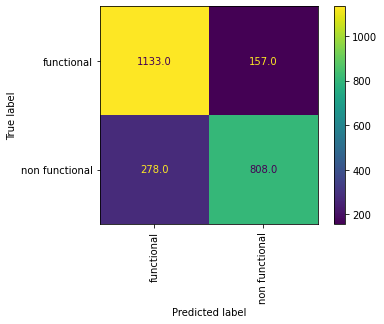

In [37]:
from sklearn.metrics import plot_confusion_matrix
#Note, yT_test has labels collapsed to 2, rather than 3
plot_confusion_matrix(pipe,X_test,yT_test,values_format = '0.1f',
                      xticks_rotation='vertical',)

In [37]:
from sklearn.metrics import classification_report

classification_report(y_test,y_pred)